In [ ]:
from pathlib import Path
from health_lifestyle_diabetes.infrastructure.data_sources.csv_dataset_repository import CSVDatasetRepository
from health_lifestyle_diabetes.infrastructure.logger.loguru_logger import LoguruLogger
from health_lifestyle_diabetes.application.use_cases.load_dataset_use_case import LoadDatasetUseCase
from health_lifestyle_diabetes.infrastructure.utils.config_loader import YamlConfigLoader
from health_lifestyle_diabetes.infrastructure.utils.paths import get_repository_root
from health_lifestyle_diabetes.infrastructure.logger.config import configure_logging
from health_lifestyle_diabetes.infrastructure.training_diagnostics.diagnostics import (
    BoostingTrainingDiagnostics,
)
from health_lifestyle_diabetes.infrastructure.tracking.run_name_generator import generate_run_name
from health_lifestyle_diabetes.infrastructure.splitters.sklearn_splitter import SklearnDatasetSplitter
from health_lifestyle_diabetes.application.use_cases.split_dataset_use_case import SplitDatasetUseCase
from health_lifestyle_diabetes.infrastructure.features_selections import features_selection as fs
from health_lifestyle_diabetes.infrastructure.model_trainers.lightgbm_trainer import (
    LightGBMTrainer,
)
from health_lifestyle_diabetes.infrastructure.model_trainers.catboost_trainer import (
    CatBoostTrainer,
)

from health_lifestyle_diabetes.infrastructure.model_trainers.xgboost_trainer import (
    XGBoostTrainer,
)



# Configure logging
configure_logging(env="dev")

# Get repository root path
root = get_repository_root()

# Load configuration
config_loader = YamlConfigLoader()
paths = config_loader.load_config(f"{root}/configs/paths.yaml")
train_paths = get_repository_root() / Path(paths["data"]["input"]["train_dataset"])

# Injection de dépendance comme en entreprise
repository = CSVDatasetRepository(source_path=train_paths, logger=LoguruLogger())
load_uc = LoadDatasetUseCase(repository=repository, logger=LoguruLogger())

# Exécution
dataset = load_uc.execute()

display(dataset.head()) # Affiche les 5 premières lignes pour validation.
print(f"le dataset chargé a {dataset.shape[0]} lignes et {dataset.shape[1]} colonnes")

2025-12-28 23:30:09 | INFO     | config.py:67 | configure_logging() | Loguru configuré avec succès (mode: dev) | {'env': 'dev'}
2025-12-28 23:30:09 | INFO     | load_dataset_use_case.py:18 | execute() | Démarrage du chargement du dataset... | {}
2025-12-28 23:30:09 | INFO     | csv_dataset_repository.py:54 | load_dataset() | Chargement du dataset depuis : /Users/surelmanda/Downloads/ml-projects/Clean-Architecture-MLops/health_lifestyle_diabetes/data/input/train.csv | {}
2025-12-28 23:30:10 | INFO     | csv_dataset_repository.py:61 | load_dataset() | Dataset chargé avec succès (963 lignes, 52 colonnes). | {}
2025-12-28 23:30:10 | INFO     | load_dataset_use_case.py:20 | execute() | Dataset chargé : 963 lignes, 52 colonnes. | {}


,Age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,...,glucose_diff,glycemic_load,dyslipidemia_flag,cardiometabolic_burden_score,bp_ratio,activity_adequacy_ratio,screen_sleep_ratio,sedentary_risk_flag,lifestyle_score,sleep_efficiency
0,44,Female,White,Highschool,Lower-Middle,Employed,Never,1,54,7.9,...,71,3306.3,1,2,1.753425,0.360000,1.072727,0,6,0.797101
1,41,Male,Black,Graduate,Middle,Inactive,Current,1,44,7.7,...,21,2839.2,1,1,1.344828,0.293333,0.054945,0,4,2.000000
2,36,Female,White,Graduate,Lower-Middle,Employed,Never,2,54,9.8,...,79,2877.0,0,1,1.630769,0.360000,1.157895,1,6,0.750000
3,54,Male,Black,Highschool,Middle,Inactive,Never,6,58,6.3,...,34,3648.0,1,3,1.224490,0.386667,0.588235,0,4,1.360000
4,58,Female,White,Graduate,Middle,Inactive,Never,0,131,9.1,...,32,2373.0,0,0,1.892308,0.873333,1.367647,1,6,0.660194


le dataset chargé a 963 lignes et 52 colonnes


In [ ]:
# 1) Load config
cfg = YamlConfigLoader().load_config(f"{get_repository_root()}/configs/splitter.yaml")["splitter"]

# 2) Logger + DI (Dépendency Injection)
logger = LoguruLogger()
splitter = SklearnDatasetSplitter(
    train_size=cfg["train_size"],
    target_column=cfg["target_column"],
    random_state=cfg["random_state"],
    logger=logger,
)

# 3) Use Case orchestré
use_case = SplitDatasetUseCase(splitter=splitter, logger=logger)
train_df, test_df = use_case.execute(df=dataset)

# 4) Vérification
#print(train_df.shape, valid_df.shape)
#train_df.head()

2025-12-28 23:30:10 | DEBUG    | sklearn_splitter.py:37 | __init__() | SklearnDatasetSplitter initialized | {}
2025-12-28 23:30:10 | INFO     | split_dataset_use_case.py:41 | execute() | Démarrage du split dataset... | {}
2025-12-28 23:30:10 | INFO     | sklearn_splitter.py:42 | split() | Starting dataset split | {}
2025-12-28 23:30:10 | INFO     | sklearn_splitter.py:57 | split() | Split done | train=(818, 52) | test=(145, 52) | {}
2025-12-28 23:30:10 | INFO     | split_dataset_use_case.py:45 | execute() | Split terminé : train=(818, 52), test=(145, 52) | {}
2025-12-28 23:30:10 | INFO     | split_dataset_use_case.py:48 | execute() | Sauvegarde des datasets splittés... | {}
2025-12-28 23:30:10 | INFO     | split_dataset_use_case.py:52 | execute() | Datasets sauvegardés avec succès. | {}


In [3]:
## 1. Importations des couches Application et Infrastructure
from health_lifestyle_diabetes.infrastructure.feature_engineering.pipeline_feature_engineering import FeatureEngineeringPipeline
from health_lifestyle_diabetes.application.use_cases.build_features_use_case import BuildFeaturesUseCase
from health_lifestyle_diabetes.infrastructure.logger.loguru_logger import LoguruLogger

## 2. Initialisation du pipeline de preprocessing et du cas d'utilisation
pipeline = FeatureEngineeringPipeline(logger=LoguruLogger())
build_features_uc = BuildFeaturesUseCase(pipeline=pipeline)
# Exécution de la transformation des données brutes en vecteurs de caractéristiques
train_enriche_df = build_features_uc.execute(data=train_df)

2025-12-28 23:30:10 | INFO     | pipeline_feature_engineering.py:82 | transform() | Démarrage du pipeline complet de Feature Engineering... | {}
2025-12-28 23:30:10 | INFO     | exclusion.py:36 | drop_leakage_columns() | Vérification des colonnes à risque de data leakage... | {}
2025-12-28 23:30:10 | INFO     | exclusion.py:44 | drop_leakage_columns() | Aucune colonne de leakage détectée. | {}
2025-12-28 23:30:10 | INFO     | base_preprocessing.py:25 | clean_categorical_variables() | Nettoyage des variables catégorielles... | {}
2025-12-28 23:30:10 | INFO     | base_preprocessing.py:32 | clean_categorical_variables() | Libellés uniformisés avec succès. | {}
2025-12-28 23:30:10 | INFO     | demographics_features.py:82 | transform() | Création des variables démographiques... | {}
2025-12-28 23:30:10 | INFO     | demographics_features.py:68 | _create_age_group() | Utilisation du découpage d'âge en 3 catégories. | {}
2025-12-28 23:30:10 | INFO     | demographics_features.py:111 | transform

In [4]:
use_case = SplitDatasetUseCase(splitter=splitter, logger=logger,save=False)
train_df_enriched, valid_df_enriched  = use_case.execute(df=train_enriche_df)
print("Dataset successfully split into training and validation sets.")
print(f"Train set shape: {train_df_enriched.shape}")
print(f"Validation set shape: {valid_df_enriched.shape}")

2025-12-28 23:30:10 | INFO     | split_dataset_use_case.py:41 | execute() | Démarrage du split dataset... | {}
2025-12-28 23:30:10 | INFO     | sklearn_splitter.py:42 | split() | Starting dataset split | {}
Dataset successfully split into training and validation sets.
Train set shape: (695, 52)
Validation set shape: (123, 52)
2025-12-28 23:30:10 | INFO     | sklearn_splitter.py:57 | split() | Split done | train=(695, 52) | test=(123, 52) | {}
2025-12-28 23:30:10 | INFO     | split_dataset_use_case.py:45 | execute() | Split terminé : train=(695, 52), test=(123, 52) | {}


In [ ]:
X_train = train_df_enriched[fs.SELECTED_FEATURES]
y_train = train_df_enriched[fs.TARGET_COLUMN]

# Pour la validation
X_valid = valid_df_enriched[fs.SELECTED_FEATURES]
y_valid = valid_df_enriched[fs.TARGET_COLUMN]
# Affichage des dimensions des matrices et vecteurs
print("Étape 5.3 : Dimensions finales des matrices de caractéristiques (X) :")
print(f"- X_train (Features d'entraînement) : {X_train.shape[0]} lignes, {X_train.shape[1]} colonnes")
print(f"- X_valid (Features de validation)  : {X_valid.shape[0]} lignes, {X_valid.shape[1]} colonnes")

print("\nÉtape 5.4 : Vérification des vecteurs cibles (y) :")
print(f"- y_train : {y_train.shape[0]} lignes")
print(f"- y_valid : {y_valid.shape[0]} lignes")

Étape 5.3 : Dimensions finales des matrices de caractéristiques (X) :
- X_train (Features d'entraînement) : 695 lignes, 5 colonnes
- X_valid (Features de validation)  : 123 lignes, 5 colonnes

Étape 5.4 : Vérification des vecteurs cibles (y) :
- y_train : 695 lignes
- y_valid : 123 lignes


2025-12-28 23:34:10 | INFO     | catboost_trainer.py:38 | __init__() | CatBoostTrainer initialisé avec les paramètres fournis. | {}
2025-12-28 23:34:10 | INFO     | catboost_trainer.py:111 | train() | Entraînement CatBoost | train_shape=(695, 5) | valid_shape=(123, 5) | {}
2025-12-28 23:34:10 | INFO     | catboost_trainer.py:127 | train() | Détection automatique des variables catégorielles : ['glucose_status'] | {}
2025-12-28 23:34:10 | INFO     | catboost_trainer.py:137 | train() | Démarrage de l'entraînement CatBoost. | {}
0:	learn: 0.5854353	test: 0.5859801	best: 0.5859801 (0)	total: 4.96ms	remaining: 7.43s
100:	learn: 0.1037828	test: 0.2163168	best: 0.2028819 (25)	total: 130ms	remaining: 1.8s
200:	learn: 0.0547542	test: 0.2349374	best: 0.2028819 (25)	total: 234ms	remaining: 1.51s
300:	learn: 0.0344240	test: 0.2659789	best: 0.2028819 (25)	total: 337ms	remaining: 1.34s
400:	learn: 0.0241266	test: 0.2827101	best: 0.2028819 (25)	total: 434ms	remaining: 1.19s
500:	learn: 0.0182406	test:

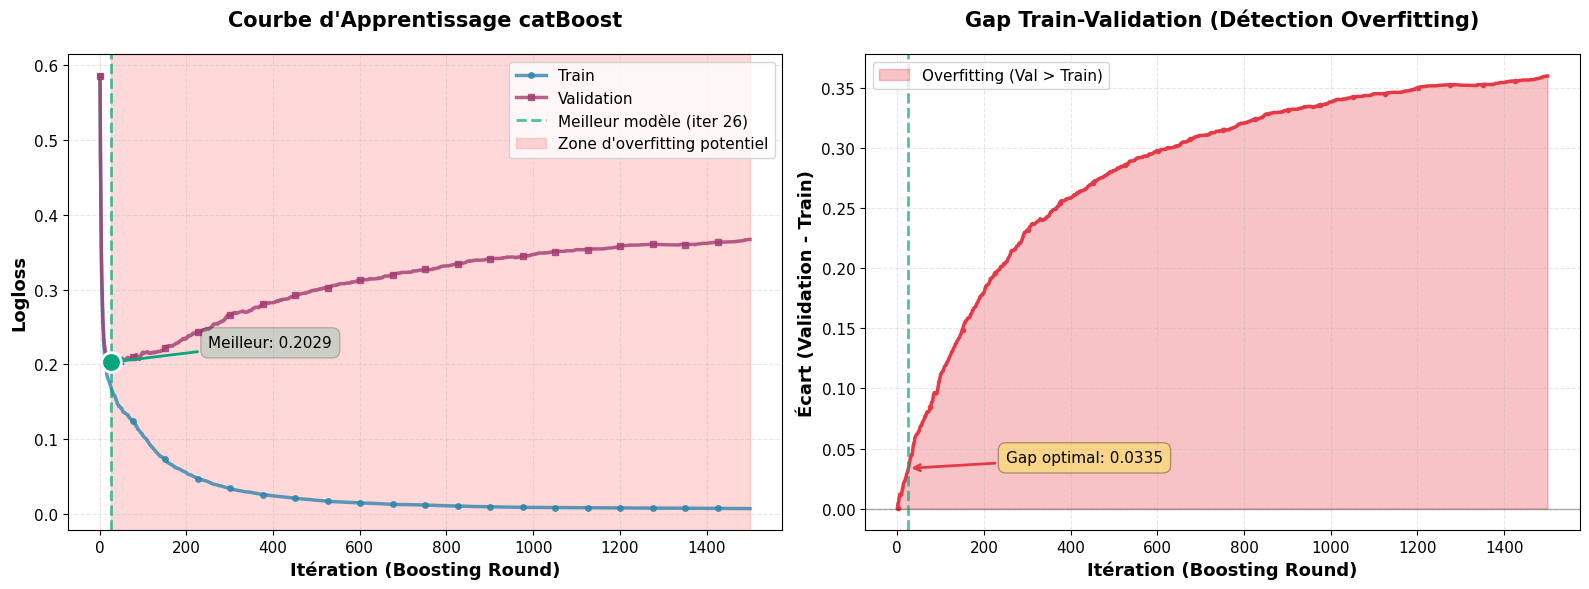

In [ ]:
# ============================================================
# Paramètres CatBoost
# ============================================================
catboost_params = {
    "iterations": 1500,
    "learning_rate": 0.1,
    "depth": 6,
    "loss_function": "Logloss",
    "eval_metric": "Logloss",  #"AUC"
    "verbose": 100,   # ← test du verbose
}

# ============================================================
# Entraînement
# ============================================================
trainer = CatBoostTrainer(params=catboost_params,logger = LoguruLogger())

model = trainer.train(
    X_train=X_train,
    y_train=y_train,
    X_valid=X_valid,
    y_valid=y_valid,
)

print("Modèle entraîné :", model)


# ============================================================
# Plot des diagnostics d'entraînement
# ============================================================
EXPERIMENT_NAME = "health_lifestyle_diabetes"
RUN_NAME = generate_run_name(prefix="CATB")
MODEL_NAME = "catBoost"

diagnostics = BoostingTrainingDiagnostics(
    model=model,
    model_name=MODEL_NAME,
    run_name=RUN_NAME,
)

diagnostics.run(
    backend="matplotlib",  # "matplotlib" ou "plotly"
    save_figure=True,
)


In [ ]:
# ============================================================
# Paramètres XGBoost
# ============================================================
xgb_params = {
    "n_estimators": 1500,
    "max_depth": 6,
    "learning_rate": 0.01,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
    "eval_metric":"logloss",   # métrique standard binaire
    #"verbose": False,
    #"early_stopping_rounds": 50,  # géré dans le trainer si valid set
}


# ============================================================
# Entraînement
# ============================================================
trainer = XGBoostTrainer(
    params=xgb_params,
    logger=LoguruLogger()
)

model = trainer.train(
    X_train=X_train,
    y_train=y_train,
    X_valid=X_valid,
    y_valid=y_valid,
)

print("Modèle XGBoost entraîné :", model)

# ============================================================
# Plot des diagnostics d'entraînement
# ============================================================
EXPERIMENT_NAME = "health_lifestyle_diabetes"
RUN_NAME = generate_run_name(prefix="XGB")
MODEL_NAME = "XGBoost"

diagnostics = BoostingTrainingDiagnostics(
    model=model,
    model_name=MODEL_NAME,
    run_name=RUN_NAME,
)

diagnostics.run(
    backend="matplotlib",  # "matplotlib" ou "plotly"
    save_figure=True,
)


2025-12-28 23:30:11 | INFO     | xgboost_trainer.py:31 | __init__() | XGBoostTrainer initialisé avec les paramètres fournis. | {}
2025-12-28 23:30:11 | INFO     | xgboost_trainer.py:91 | train() | XGBoost - Entraînement | train=(695, 5), valid=(123, 5) | {}
2025-12-28 23:30:11 | DEBUG    | xgboost_trainer.py:95 | train() | XGBoost - Hyperparamètres: {'n_estimators': 1500, 'max_depth': 6, 'learning_rate': 0.01, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 42, 'eval_metric': 'logloss'} | {}
2025-12-28 23:30:11 | INFO     | xgboost_trainer.py:101 | train() | XGBoost - Variables catégorielles détectées : ['glucose_status'] | {}
2025-12-28 23:30:11 | INFO     | xgboost_trainer.py:114 | train() | XGBoost - Démarrage de l'entraînement... | {}
[0]	validation_0-logloss:0.66625	validation_1-logloss:0.66547
[1]	validation_0-logloss:0.65908	validation_1-logloss:0.65855
[2]	validation_0-logloss:0.65190	validation_1-logloss:0.65200
[3]	validation_0-logloss:0.64483	validation_1-logloss:

In [ ]:
# ============================================================
# Paramètres LightGBM
# ============================================================
lgbm_params = {
    "n_estimators": 1500,
    "learning_rate": 0.01,
    "max_depth": 4,
    "num_leaves": 31,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
    "metric": "logloss",          # métrique suivie pendant l'entraînement
    #"early_stopping_rounds": 50,  # géré si un jeu de validation est fourni
    "verbosity": -1,  # masque tous les logs
}


# ============================================================
# Entraînement
# ============================================================
trainer = LightGBMTrainer(
    params=lgbm_params,
    logger=LoguruLogger()
)

model = trainer.train(
    X_train=X_train,
    y_train=y_train,
    X_valid=X_valid,
    y_valid=y_valid,
)

print("Modèle LightGBM entraîné :", model)

# ============================================================
# Plot des diagnostics d'entraînement
# ============================================================
EXPERIMENT_NAME = "health_lifestyle_diabetes"
RUN_NAME = generate_run_name(prefix="LGBM")
MODEL_NAME = "LightGBM"

diagnostics = BoostingTrainingDiagnostics(
    model=model,
    model_name=MODEL_NAME,
    run_name=RUN_NAME,
)

diagnostics.run(
    backend="matplotlib",      # "matplotlib" ou "plotly"
    save_figure=True,
)

2025-12-28 23:30:14 | INFO     | lightgbm_trainer.py:20 | __init__() | Initialisation LightGBMTrainer terminée. | {}
2025-12-28 23:30:14 | DEBUG    | lightgbm_trainer.py:30 | train() | Début de la méthode train() | {}
2025-12-28 23:30:14 | INFO     | lightgbm_trainer.py:33 | train() | Validation des données... | {}
2025-12-28 23:30:14 | INFO     | lightgbm_trainer.py:42 | train() | Taille train: (695, 5) | {}
2025-12-28 23:30:14 | INFO     | lightgbm_trainer.py:43 | train() | Taille valid: (123, 5) | {}
2025-12-28 23:30:14 | INFO     | lightgbm_trainer.py:51 | train() | Détection et conversion des colonnes catégorielles... | {}
2025-12-28 23:30:14 | DEBUG    | lightgbm_trainer.py:55 | train() | Colonnes catégorielles détectées: ['hba1c', 'glucose_fasting'] | {}
2025-12-28 23:30:14 | INFO     | lightgbm_trainer.py:58 | train() | Initialisation du modèle LightGBM... | {}
2025-12-28 23:30:14 | DEBUG    | lightgbm_trainer.py:59 | train() | Hyperparamètres LightGBM: {'n_estimators': 1500, '

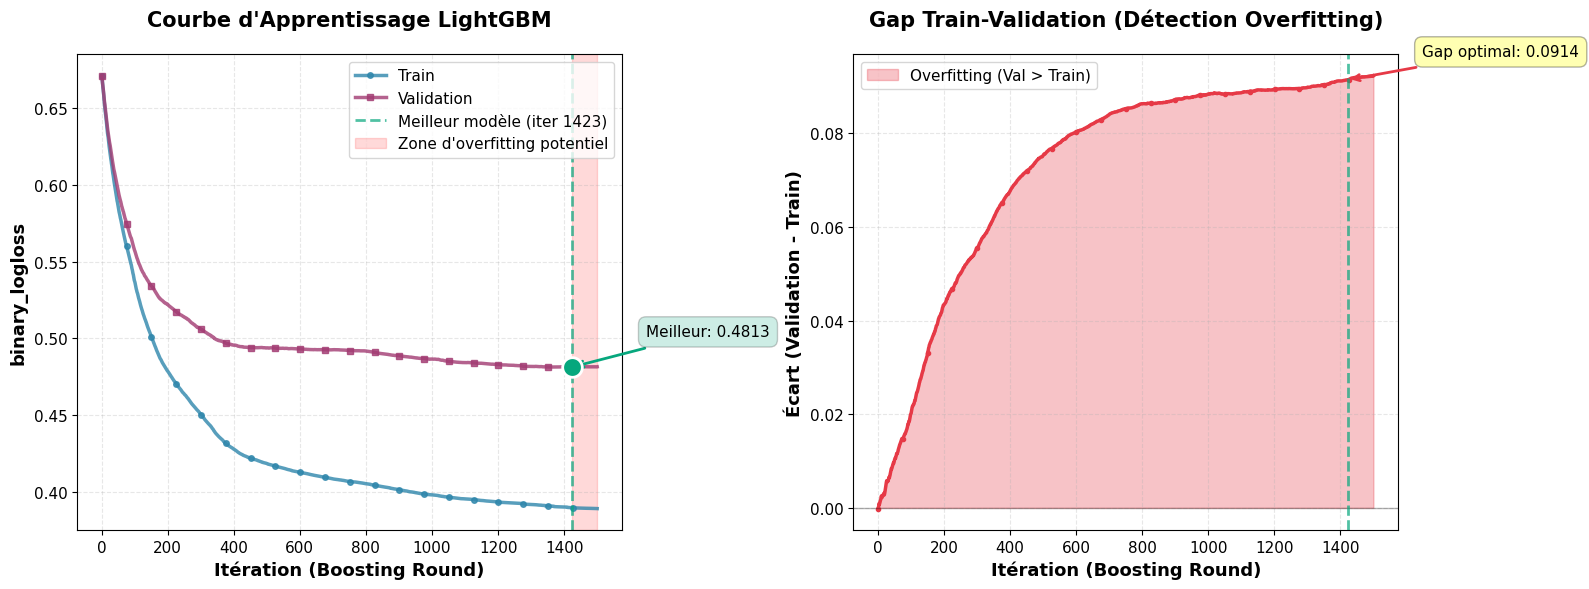

In [ ]:
# ============================================================
# 5.) Plot des diagnostics d'entraînement
# ============================================================
EXPERIMENT_NAME = "health_lifestyle_diabetes"
RUN_NAME = generate_run_name(prefix="LGBM")
MODEL_NAME = "LightGBM"

diagnostics = BoostingTrainingDiagnostics(
    model=model,
    model_name=MODEL_NAME,
    run_name=RUN_NAME,
)

diagnostics.run(
    backend="matplotlib",      # "matplotlib" ou "plotly"
    save_figure=True,
)